# Map 7 - Faults and unconformity
This map is from Bennison et al. (2011). It has dipping layers, two faults, and an unconformity. First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

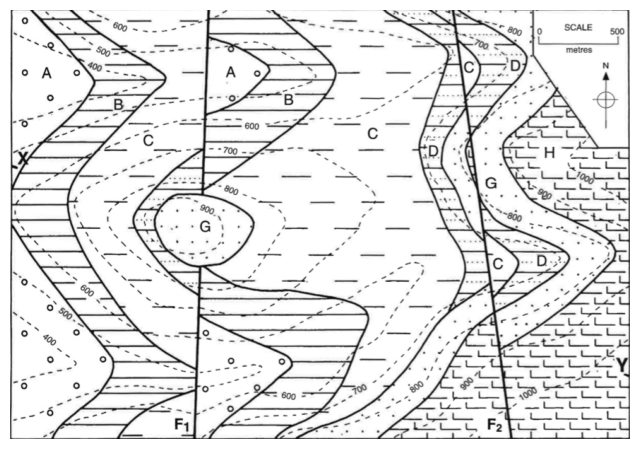

In [2]:
# Display map image
img = mpimg.imread("map7.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

In [4]:
# Read the topographic contours
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,25.73,358.37,400,POINT (25.73000 358.37300)
1,71.53,373.33,400,POINT (71.52600 373.33200)
2,118.73,389.65,400,POINT (118.72900 389.64900)
3,174.64,401.61,400,POINT (174.63600 401.61300)
4,231.06,418.11,400,POINT (231.06400 418.10500)


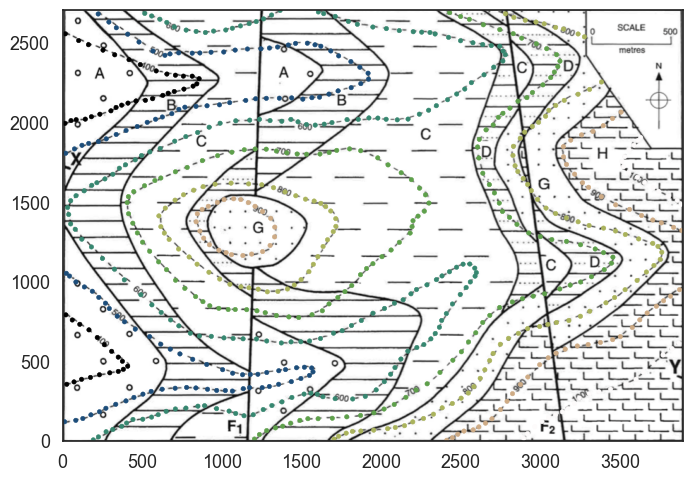

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 3893, 0, 2709], cmap="gray")
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", markersize=10)
ax.set_ylim((0,2709))
ax.set_xlim((0,3893));

### Interpolate the contour lines to make a digital elevation model (DEM)

In [6]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

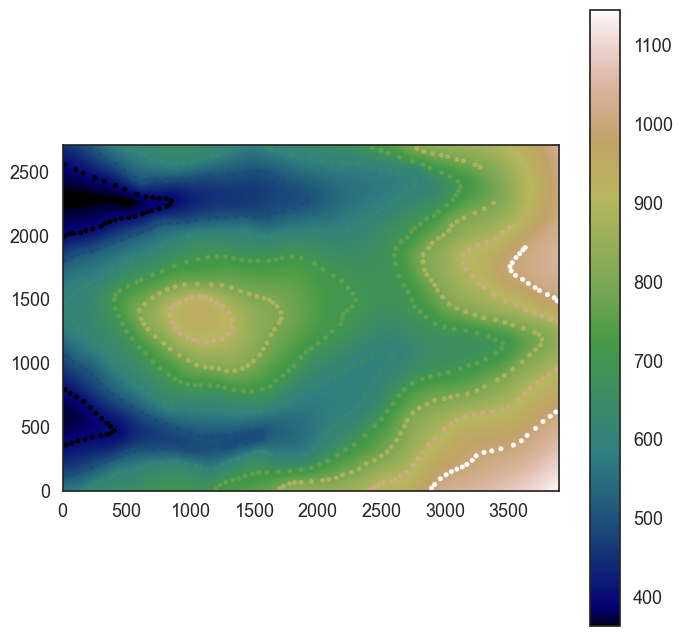

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth", markersize=10)
im = ax.imshow(topo_raster, origin="lower", extent=[0, 3893, 0, 2709], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map7.tif", 
                       extent=[0, 3893, 0, 2709], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map7.tif")

## 2. Stratigraphic boundaries or units' contacts

In [10]:
# Read the contacts. These are the bases of the units and the two faults
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,386.36,818.76,B,POINT (386.36400 818.76000)
1,464.89,2146.34,B,POINT (464.89100 2146.33700)
2,1532.15,2220.14,B,POINT (1532.14800 2220.13900)
3,1585.73,589.43,B,POINT (1585.72700 589.42900)
4,918.66,2331.52,C,POINT (918.66300 2331.52300)


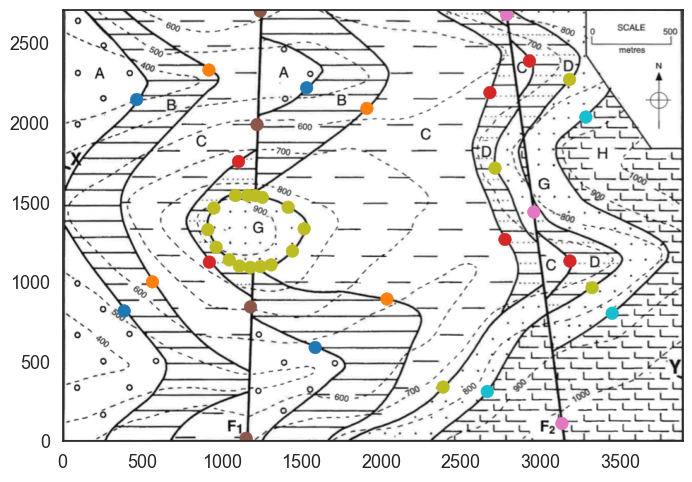

In [11]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 3893, 0, 2709], cmap="gray")
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,2709))
ax.set_xlim((0,3893));

In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,386.36,818.76,B,POINT (386.36400 818.76000),530.88
1,464.89,2146.34,B,POINT (464.89100 2146.33700),398.44
2,1532.15,2220.14,B,POINT (1532.14800 2220.13900),478.83
3,1585.73,589.43,B,POINT (1585.72700 589.42900),569.11
4,918.66,2331.52,C,POINT (918.66300 2331.52300),421.69


We digitize more points on the uncomformity above fault F1 to properly represent that this surface formed after the fault (F1 is older than the unconformity). However, fault F2 displaces the unconformity (i.e. F2 is younger than the unconformity).

### Strike lines

In [13]:
# Read the strike lines on bases B and C, and faults F1 and F2
gdf = df_to_gdf(os.path.join("strike_lines", "strike_lines.txt"), sep="\t")
gdf.head()

,X,Y,Z,formation,id,geometry
0,2105.93,871.07,600,C,1,POINT (2105.93400 871.07300)
1,1827.82,2017.45,600,C,1,POINT (1827.82300 2017.45200)
2,1764.81,939.32,700,C,2,POINT (1764.81000 939.32100)
3,1548.55,1796.90,700,C,2,POINT (1548.54800 1796.89800)
4,1422.92,966.30,800,C,3,POINT (1422.92200 966.29600)


In [14]:
# Convert the points into strike lines
linestring_gdf_C = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "C"])
linestring_gdf_G = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "G"])
linestring_gdf_F1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "F1"])
linestring_gdf_F2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "F2"])

In [15]:
# Check that the strike lines are valid
print("C\n", linestring_gdf_C.is_valid)
print("G\n", linestring_gdf_G.is_valid)
print("F1\n", linestring_gdf_F1.is_valid)
print("F2\n", linestring_gdf_F2.is_valid)

C
 0    True
1    True
2    True
dtype: bool
G
 0    True
1    True
dtype: bool
F1
 0    True
1    True
2    True
dtype: bool
F2
 0    True
1    True
dtype: bool


In [16]:
# Ignore warnings from np produced by the vertical faults
import warnings
warnings.filterwarnings("ignore")

# Calculate orientations for base C
orientations_C = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_C)
# Calculate orientations for base G (unconformity)
orientations_G = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_G)
# Calculate orientations for fault F1
orientations_F1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_F1)
# Calculate orientations for fault F2
orientations_F2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_F2)
# print orientations
print(f"C dip = {orientations_C.iloc[0,0]:.2f}, azimuth = {orientations_C.iloc[0,1]:.2f}")
print(f"G dip = {orientations_G.iloc[0,0]:.2f}, azimuth = {orientations_G.iloc[0,1]:.2f}")
print(f"F1 dip = {orientations_F1.iloc[0,0]:.2f}, azimuth = {orientations_F1.iloc[0,1]:.2f}")
print(f"F2 dip = {orientations_F2.iloc[0,0]:.2f}, azimuth = {orientations_F2.iloc[0,1]:.2f}")

C dip = 17.59, azimuth = 76.18
G dip = 5.92, azimuth = 90.56
F1 dip = 90.00, azimuth = 271.68
F2 dip = 90.00, azimuth = 82.37


Units A to D dip 18 degrees to the east. Units G and H above the unconformity dip 6 degrees east. Faults F1 and F2 are vertical. This is clear by the straight trace of these faults in the map.

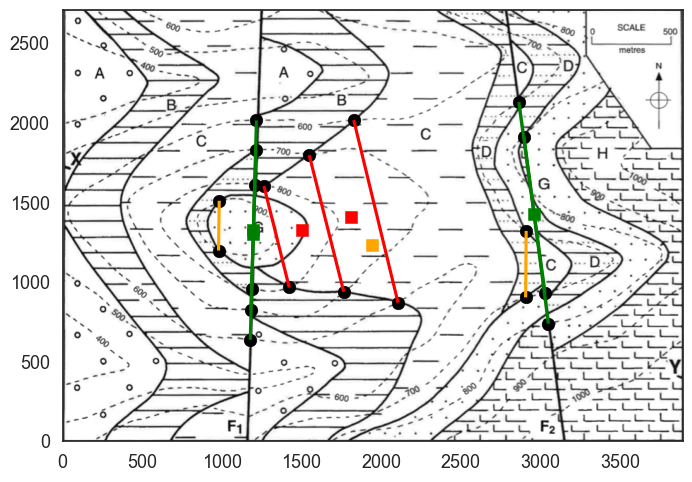

In [17]:
# Plot all this information, squares are orientations
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.imshow(img, extent=[0, 3893, 0, 2709], cmap="gray")   
# plot points
gdf.plot(ax=ax, aspect="equal", color="black")
# plot strike lines
# base C
linestring_gdf_C.plot(ax=ax, aspect="equal", color="red")
orientations_C.plot(ax=ax, aspect="equal", color="red", marker="s")
# base G
linestring_gdf_G.plot(ax=ax, aspect="equal", color="orange") 
orientations_G.plot(ax=ax, aspect="equal", color="orange", marker="s")
# fault F1
linestring_gdf_F1.plot(ax=ax, aspect="equal", color="green")
orientations_F1.plot(ax=ax, aspect="equal", color="green", marker="s")
# fault F2
linestring_gdf_F2.plot(ax=ax, aspect="equal", color="green") 
orientations_F2.plot(ax=ax, aspect="equal", color="green", marker="s");

In [18]:
# Merge orientations
orientations = pd.concat([orientations_C,orientations_G, orientations_F1, orientations_F2]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,17.59,76.18,650.00,POINT (1811.77875 1406.18600),1.00,1811.78,1406.19,C
1,1,17.19,75.90,750.00,POINT (1500.05050 1326.44950),1.00,1500.05,1326.45,C
2,0,5.92,90.56,800.00,POINT (1944.91475 1233.45175),1.00,1944.91,1233.45,G
3,0,90.00,271.68,650.00,POINT (1197.52125 1326.51475),1.00,1197.52,1326.51,F1
4,1,89.44,271.79,750.00,POINT (1197.72950 1304.55075),1.00,1197.73,1304.55,F1


## 3. Construction of the model in GemPy

In [19]:
# Create a geomodel object called model7
geo_model = gp.create_model("model7")

In [20]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 3893, 0, 2709, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [21]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,B,Default series,1,#015482,1
1,C,Default series,2,#9f0052,2
2,D,Default series,3,#ffbe00,3
3,H,Default series,4,#728f02,4
4,F1,Default series,5,#443988,5
5,F2,Default series,6,#ff3f20,6
6,G,Default series,7,#5DA629,7


In [22]:
# The base of the lowermost unit A does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("A")

# Group the units into series
# Fault1 and Fault2 = faults, Strata1 = Units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model,
                         {"Fault1": ("F1"), "Fault2": ("F2"), "Strata1": ("H","G"), 
                          "Strata2": ("D","C","B","A"),},
                         remove_unused_series=True)

# Tell GemPy that there are two faults
geo_model.set_is_fault(["Fault1"])
geo_model.set_is_fault(["Fault2"])

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault1,1,Fault,True,True,False
Fault2,2,Fault,True,True,False
Strata1,3,Erosion,True,False,False
Strata2,4,Erosion,True,False,False


In [23]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
4,F1,Fault1,1,False,True,True,True,#527682,NaN,NaN,NaN,1,4,2
5,F2,Fault2,1,False,True,True,True,#527682,NaN,NaN,NaN,2,3,1
3,H,Strata1,1,False,False,True,True,#728f02,NaN,NaN,NaN,3,3,0
6,G,Strata1,2,False,False,True,True,#5DA629,NaN,NaN,NaN,4,19,1
0,B,Strata2,1,False,False,True,True,#015482,NaN,NaN,NaN,5,4,0
1,C,Strata2,2,False,False,True,True,#9f0052,NaN,NaN,NaN,6,4,2
2,D,Strata2,3,False,False,True,True,#ffbe00,NaN,NaN,NaN,7,6,0
7,A,Strata2,4,True,False,True,True,#4878d0,NaN,NaN,NaN,8,0,0


In [24]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map7.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [25]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [26]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer="fast_compile");

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                        values
range                 4847.07
$C_o$               559384.05
drift equations  [3, 3, 3, 3]


In [27]:
# Compute model
gp.compute_model(geo_model);

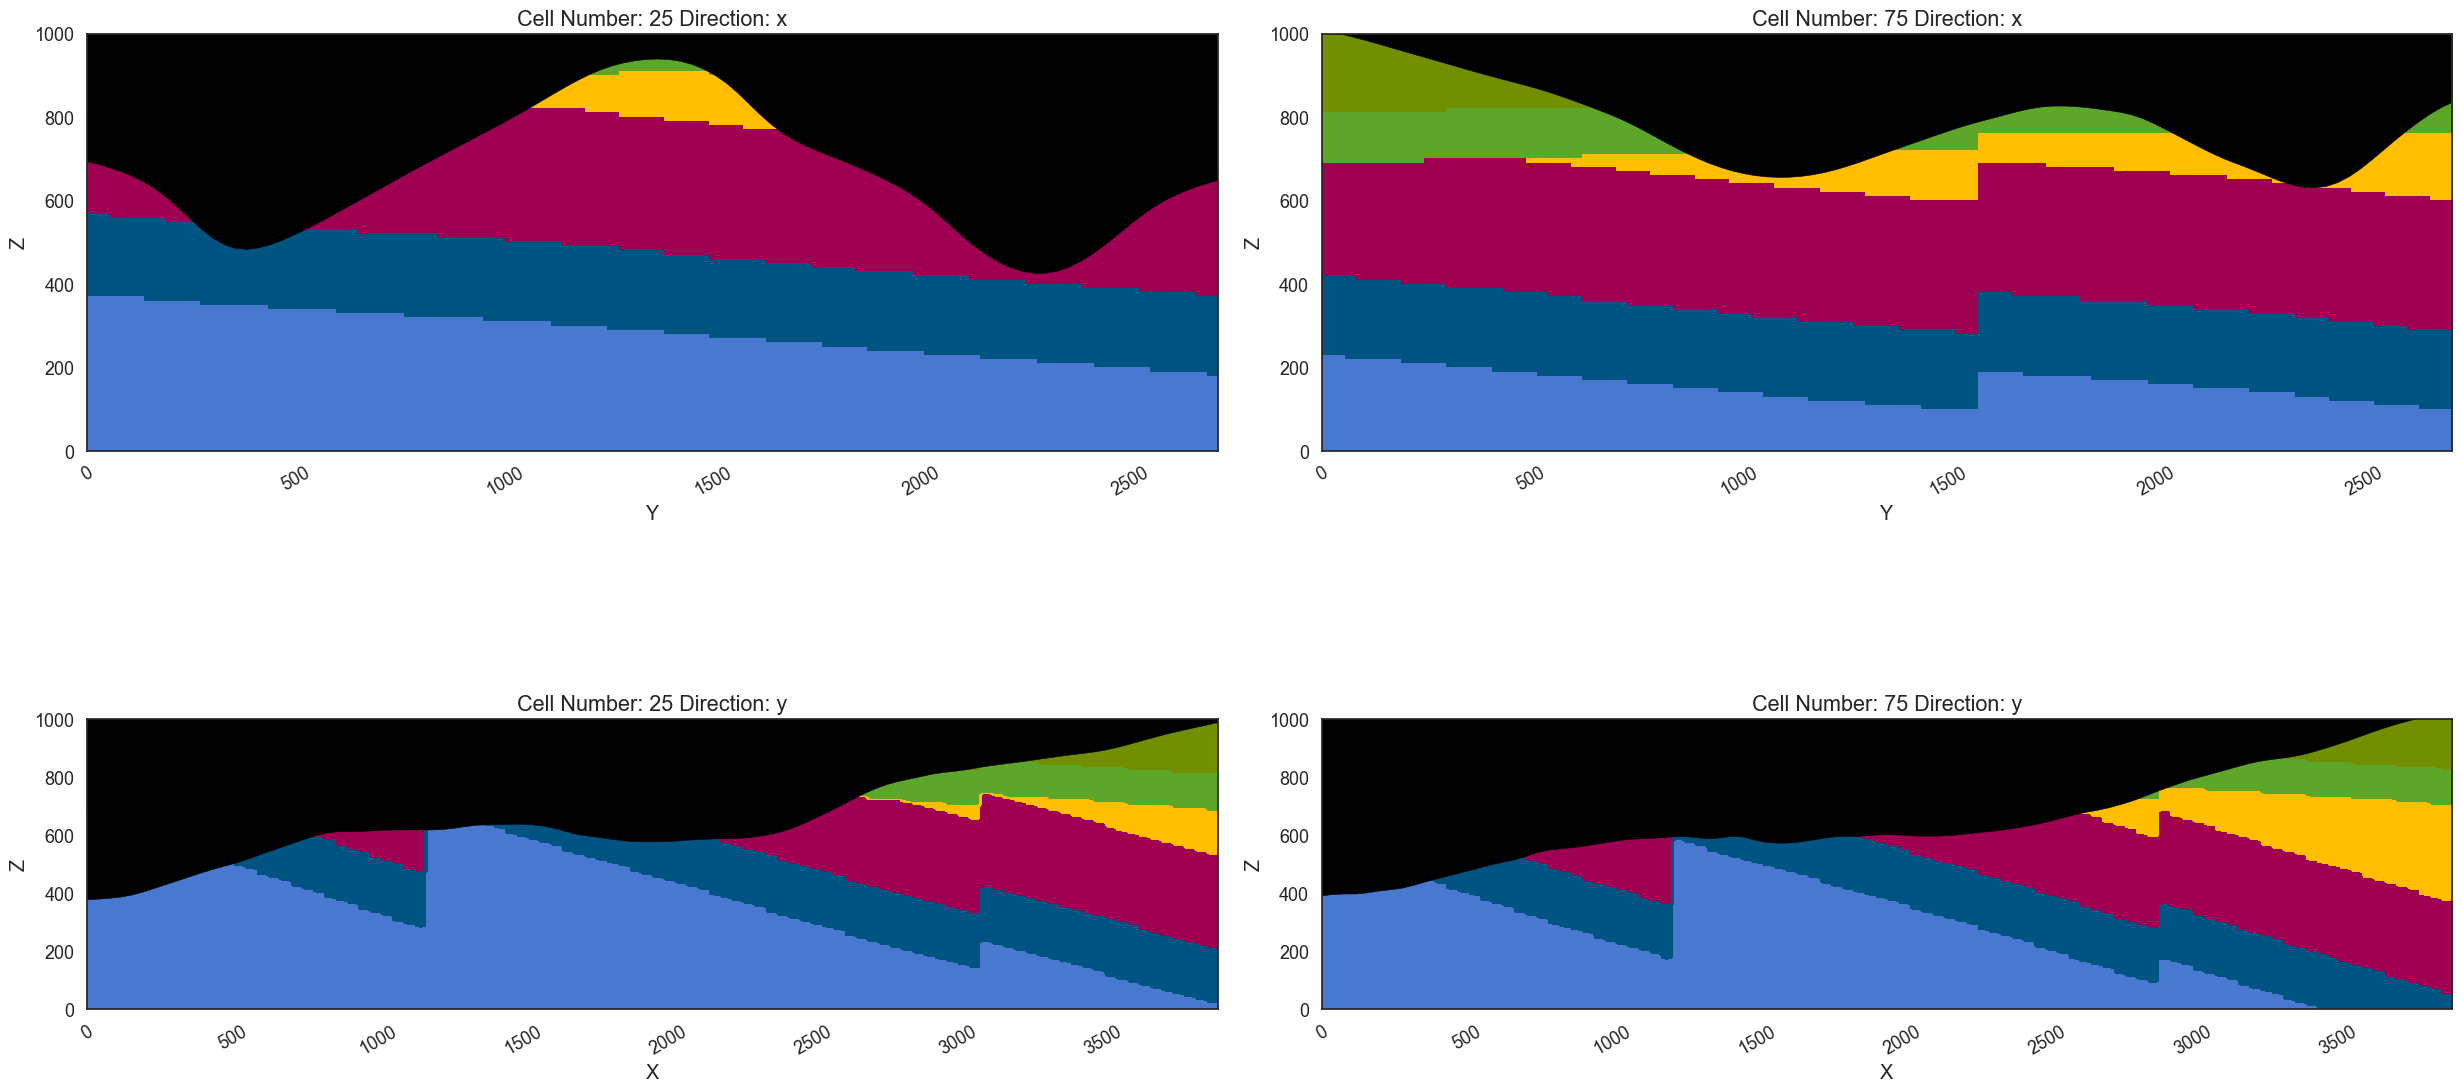

In [28]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [29]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);